**Import Necessary Modules**

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

**Load CIFAR10 datasets**

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)



In [10]:
encoder=models.Sequential([
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(32,3,activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(2)  #2D Latent space
])
decoder = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8 * 8 * 64, activation='relu'),
    layers.Reshape((8, 8, 64)),
    layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])

input_img = tf.keras.Input(shape=(32, 32, 3))
encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = tf.keras.Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 2)              │        27,586 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 32, 32, 3)      │        68,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,133 (375.52 KB)

 Trainable params: 96,133 (375.52 KB)

 Non-trainable params: 0 (0.00 B)

**Train AutoEncoder**

In [11]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 227s 573ms/step - loss: 0.0466 - val_loss: 0.0374
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 233s 597ms/step - loss: 0.0373 - val_loss: 0.0371
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 241s 542ms/step - loss: 0.0370 - val_loss: 0.0369
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 255s 524ms/step - loss: 0.0369 - val_loss: 0.0369
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 263s 528ms/step - loss: 0.0369 - val_loss: 0.0367
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 215s 549ms/step - loss: 0.0368 - val_loss: 0.0368
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 262s 549ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 266s 557ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 216s 553ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 260s 547ms/step - loss: 0.0365 - val_loss: 0.0367


**Extract 2D Features**

In [13]:
encoded_features = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


**Visualize 2D Features**

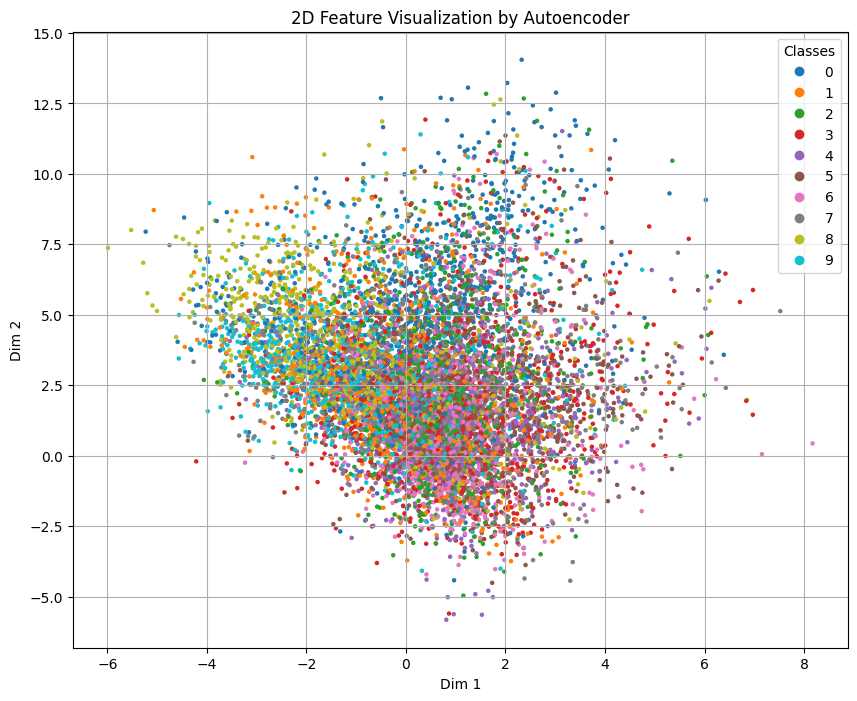

In [16]:

import numpy as np
import matplotlib.pyplot as plt
y_colors = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test.ravel()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    encoded_features[:, 0],
    encoded_features[:, 1],
    c=y_colors,
    cmap='tab10',
    s=5
)

plt.legend(*scatter.legend_elements(), title="Classes", loc="best")

plt.title("2D Feature Visualization by Autoencoder")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()



**Pre-trained CNN (MobileNetV2) Feature Comparison**

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Resize CIFAR-10 to MobileNetV2 input**

In [18]:
x_test_resized = tf.image.resize(x_test, (96, 96))
cnn_features = base_model.predict(x_test_resized, batch_size=128)

79/79 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step


In [19]:
# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cnn_features)
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(cnn_features)

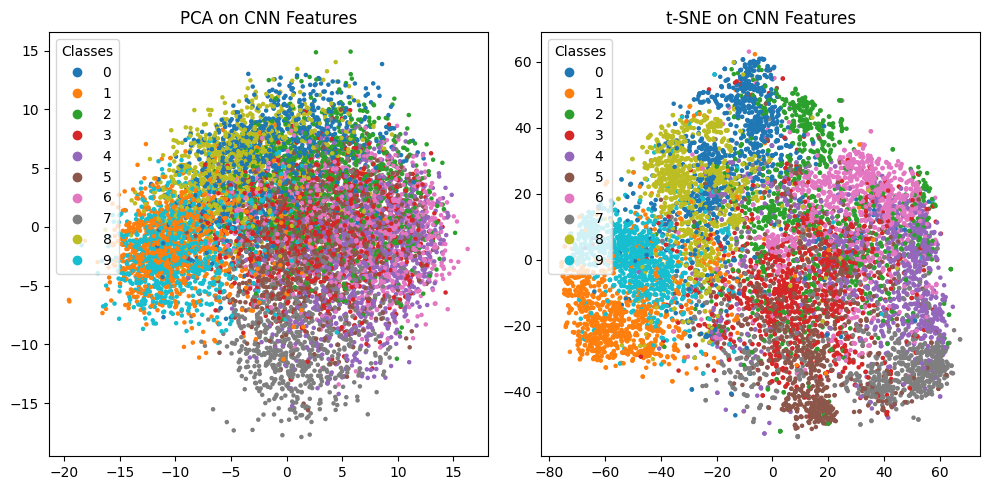

In [23]:
# Plot PCA features
y_colors = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test.ravel()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=y_colors, cmap='tab10', s=5)
plt.title("PCA on CNN Features")
plt.legend(*scatter.legend_elements(), title="Classes")

# Plot t-SNE features
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_colors, cmap='tab10', s=5)
plt.title("t-SNE on CNN Features")
plt.legend(*scatter.legend_elements(), title="Classes")

plt.tight_layout()
plt.show()